# Project 4: Stereo Matching with ML

This is Project 4 for [UW CSE P576 Computer Vision](https://courses.cs.washington.edu/courses/csep576/18sp/).

**Getting Started:** Download the [source ipynb](https://courses.cs.washington.edu/courses/csep576/18sp/projects/project4/project4.zip) for this notebook and use File->Upload Notebook in Colab. 

**This project:** In this project you will build a model for stereo matching. First, you'll implement and test standard block matching as a Tensorflow graph. Next, you will add a convolutional net to the output of your block matcher, and train the network using images from the KITTI dataset.

**What to turn in:** Turn in a pdf of your completed ipynb notebook as well as the source .ipynb. Clearly describe any enhancements or experiments you tried in your ipynb notebook.

`version 051618`

### Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");

This is not an official Google product.


In [ ]:
#@title 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Setup

In [52]:
import numpy as np
import tensorflow as tf
import PIL.Image as pil
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 10.0)

tf.logging.set_verbosity(tf.logging.INFO)

def image_open(filename):
  """
  Returns a numpy float image with values in the range (0,1)
  """
  pil_im = pil.open(filename)
  im_np = np.array(pil_im).astype(np.float32)
  im_np /= 255.0
  return im_np

def grey_to_rgb(img):
  """
  Convert greyscale to rgb image
  """
  if (len(img.shape)==2):
    img = np.expand_dims(img, 2)

  img3 = np.repeat(img, 3, 2)
  return img3

def normalise_01(im):
  """
  Normalise image to the range (0,1)
  """
  mx = im.max()
  mn = im.min()
  den = mx-mn
  small_val = 1e-9
  if (den < small_val):
    print('image normalise_01 -- divisor is very small')
    den = small_val
  return (im-mn)/den

In [53]:
#@title
# Download KITTI data
#!wget -nc https://courses.cs.washington.edu/courses/csep576/18sp/projects/project4/kitti_stereo2012.zip && unzip -n kitti_stereo2012.zip

## Visualising KITTI data [15%]

We'll start by reading in some images to perform block matching on. The code below displays a random left image, and the average of left and right images. You should see that the pixel difference (disparity) for nearby objects is larger for foreground objects than for distant ones.

### Modification

Modified code to visualize right, left, average, and disparity image.

(-0.5, 1240.5, 375.5, -0.5)

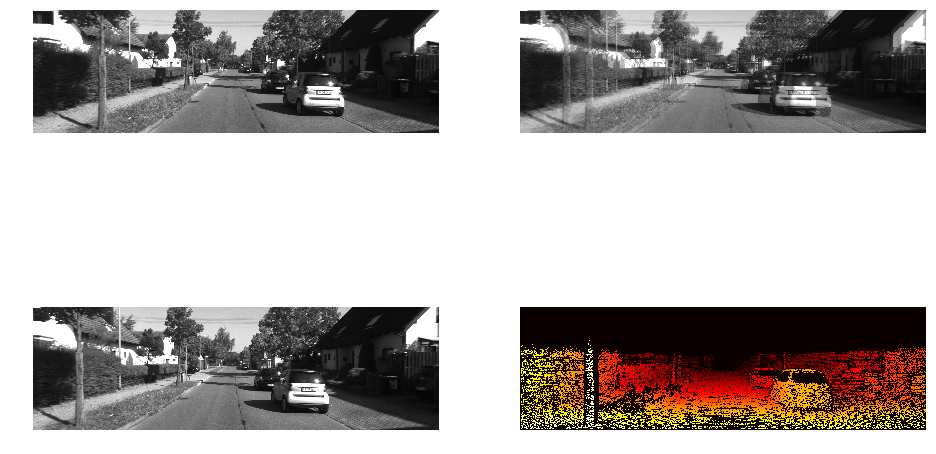

In [137]:
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color
import scipy

# Visualise left,right and disparity images
num_data=194
im_id=np.random.randint(num_data)

left_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/image_0/'+str(im_id).zfill(6)+'_10.png'))
right_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/image_1/'+str(im_id).zfill(6)+'_10.png'))
disp_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/disp_occ/'+str(im_id).zfill(6)+'_10.png'))

left_im=tf.to_float(left_im[:,:,0])/255.0
right_im=tf.to_float(right_im[:,:,0])/255.0
disp_im=tf.to_float(disp_im[:,:,0])

sess=tf.Session()
left_im_np=sess.run(left_im)
right_im_np=sess.run(right_im)
disp_im_np=sess.run(disp_im)
sess.close()

plt.subplot(2,2,1)
plt.imshow(grey_to_rgb(left_im_np))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(grey_to_rgb(0.5*left_im_np+0.5*right_im_np))
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(grey_to_rgb(right_im_np))
plt.axis('off')
plt.subplot(2,2,4)

# https://matplotlib.org/users/colormaps.html#grayscale-conversion
# Red -> Yellow ::: Low -> High disparity value
plt.imshow(disp_im_np, cmap=plt.cm.get_cmap('hot'))
plt.axis('off')




Complete the code block below to visualise the ground truth disparity data. What is the approximate disparity range? Hint: try using `np.histogram` with a set of images. Which regions of the image have valid disparity values? Try a averaging over a several images to visualise the spatial range of the depth data.

Total # of Pixels
(8785130,)
Max=
157.0
Min=
0.0
Median=
0.0
Average=
11.405221


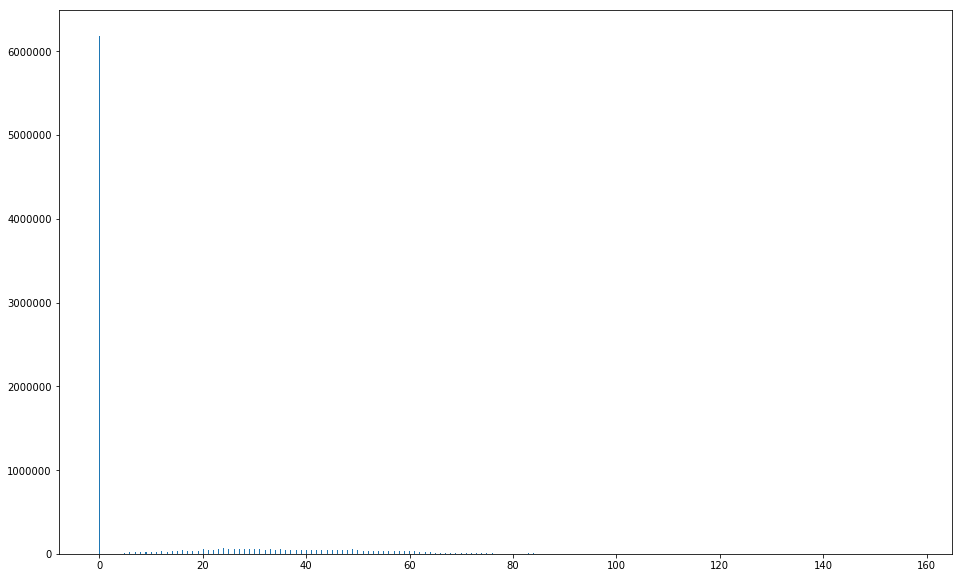

In [70]:
"""
********************************************************
*** TODO: write code to visualise disparity ground truth
********************************************************
"""
disp_im_nps = None
sess=tf.Session()
## Here we plot the disparity values of the first 10% images
for im_id in range(num_data//10):
    disp_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/disp_occ/'+str(im_id).zfill(6)+'_10.png'))
    disp_im=tf.to_float(disp_im[:,:,0])

    disp_im_np=sess.run(disp_im) # Each of these is heightxwidth of image
    if disp_im_nps is None:
        disp_im_nps = np.ndarray.flatten(disp_im_np)
    else:
        disp_im_nps = np.concatenate((disp_im_nps, np.ndarray.flatten(disp_im_np)))
    
sess.close()    
# Approximate Disparity range (per pixel)
print('Total # of Pixels')
print(disp_im_nps.shape)
print('Max=')
print(np.amax(disp_im_nps))
print('Min=')
print(np.amin(disp_im_nps))
print('Median=')
print(np.median(disp_im_nps))
print('Average=')
print(np.average(disp_im_nps))
plt.hist(disp_im_nps, bins='auto')
plt.show()

#

### Averaging 
Here we average over the disparity values of different sets of 50 images and plot the disparity map

Most of the plots are similar
* Higher disparity values in lower center OR objects in foreground have higher disparity values
* 0 disparity values in upper 25% of the image OR objects in background have lower disparity values
* 

/Users/jaipreet/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00945762 0.04858884 ... 0.04638778 0.03398929 0.00272988]
 [0.         0.00479694 0.00980184 ... 0.01352816 0.00605067 0.00086758]
 [0.         0.         0.         ... 0.         0.         0.        ]]


(-0.5, 999.5, 299.5, -0.5)

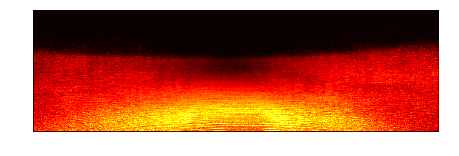

In [128]:
import skimage # v0.13
total_sum = np.zeros((300,1000))
sess=tf.Session()
num = 50
low = 100
for im_id in range(low,low+num):
    disp_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/disp_occ/'+str(im_id).zfill(6)+'_10.png'))
    disp_im=disp_im[:,:,0]
    disp_im_np=sess.run(disp_im) # Each of these is height x width of image
    scaled_disp_im_np = skimage.transform.resize(disp_im_np, (300,1000))
    total_sum = np.add(total_sum, scaled_disp_im_np)
    
sess.close()  

avg = total_sum / num
print(avg)
plt.subplot(1,2,1)
plt.imshow(avg / 255., cmap=plt.cm.get_cmap('hot'))
plt.axis('off')

## Block Matching in Tensorflow [25%]

You will now write Tensorflow code to perform block matching. Edit the function `compute_cost_volume` below to compute a 3D tensor such that `cost_volume[row,col,disparity]` is the SSD between a patch of size `block_match_size` from the left image, and a patch shifted by `disparity` pixels in the right image. Hint: try the Tensorflow functions `tf.extract_image_patches` and `tf.manip.roll`. 

In [138]:
def compute_cost_volume(left_im, right_im,block_match_size,disparity_range):
  
  # FORNOW: random cost volume  
  cost_volume=tf.random_normal([370,1226,disparity_range])
  
  """
  **************************************************************
  *** TODO: write code to compute the block matching cost volume
  **************************************************************

  Inputs: left_im=left image (H, W)
          right_im=right image (H, W)
          block_match_size=size of square for patch matching
          disparity_range=range of disparities to compute

  Outputs: cost_volume=output cost volume (H, W, disparity_range)
  """
  for d in range(disparity_range):
    pass
    
  
  """
  **************************************************************
  """
  
  return cost_volume

The code below calls `compute_cost_volume` and finds the min cost at each pixel to estimate disparity. Check the output looks sensible. What is the effect of `block_match_size` and `disparity_range` on the results?

(-0.5, 1225.5, 369.5, -0.5)

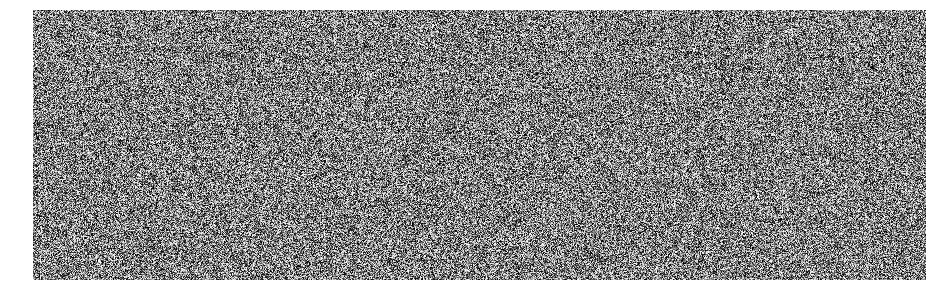

In [139]:
cost_vol=compute_cost_volume(left_im,right_im,block_match_size=3,disparity_range=80)
block_est=tf.argmin(cost_vol,axis=2)
block_est=tf.to_float(block_est)

sess=tf.Session()
cost_vol_np=sess.run(cost_vol)
block_est_np=sess.run(block_est)
sess.close()

plt.subplot(1,1,1)
plt.imshow(grey_to_rgb(normalise_01(block_est_np)))
plt.axis('off')

The code below uses the `compute_cost_volume` function in a data provider that creates batches by extracting patches from the training data. In subsequent experiments, you can adjust block matching settings using the parameters in the `StereoDataProvider` class.

In [140]:
#@title
class StereoDataProvider:
  """
  Provide data for stereo images
  """
  def __init__(self):
    self.params={}
    self.params['patch_size']=64
    self.params['num_patches_per_image']=100
    self.params['block_match_size']=3
    self.params['disparity_range']=80
    self.params['ignore_top_rows']=100
    self.params['batch_size']=5
    self.params['shuffle_buffer_size']=1000
    self.params['prefetch_buffer_size']=2
    self.params['num_epochs']=10
    self.params['height']=370
    self.params['width']=1226

    self.input_filenames=[]
    self.target_filenames=[]

  def get_batch(self):
    # get a batch of patch data
    dataset=tf.data.Dataset.from_tensor_slices((self.input_filenames,self.target_filenames))

    dataset=dataset.repeat(self.params['num_epochs'])
    dataset=dataset.map(self.read_images)
    dataset=dataset.map(self.preprocess_images)
    dataset=dataset.map(self.get_patches)
    dataset=dataset.apply(tf.contrib.data.unbatch())
    dataset=dataset.shuffle(buffer_size=self.params['shuffle_buffer_size'])
    dataset=dataset.batch(self.params['batch_size'])
    dataset=dataset.prefetch(self.params['prefetch_buffer_size'])

    iterator=dataset.make_one_shot_iterator()
    dataset_element=iterator.get_next()

    return dataset_element

  def get_preprocessed_images(self):
    # get preprocessed images for inference
    dataset=tf.data.Dataset.from_tensor_slices((self.input_filenames,self.target_filenames))

    dataset=dataset.map(self.read_images)
    dataset=dataset.map(self.preprocess_images)
    dataset=dataset.batch(1)
    dataset=dataset.prefetch(1)

    iterator=dataset.make_one_shot_iterator()
    dataset_element=iterator.get_next()

    return dataset_element

  def read_images(self,input_filenames,target_filename):

    left_im=tf.image.decode_image(tf.read_file(input_filenames[0]))
    right_im=tf.image.decode_image(tf.read_file(input_filenames[1]))
    disp_im=tf.image.decode_image(tf.read_file(target_filename))

    height=self.params['height']
    width=self.params['width']

    left_im=left_im[0:height,0:width,0]
    right_im=right_im[0:height,0:width,0]
    disp_im=disp_im[0:height,0:width,0]

    # set shape explicitly (ambiguous due to image read)
    left_im.set_shape((height,width))
    right_im.set_shape((height,width))
    disp_im.set_shape((height,width))

    input_data=tf.to_float(tf.stack((left_im,right_im),2))/255.0 # images in range 0-1
    target_disp=tf.to_float(tf.expand_dims(disp_im,2)) # disparity in pixels

    return (input_data,target_disp)

  def preprocess_images(self,input_data,target_disp):
    # preprocess images to help depth learning
    block_match_size=self.params['block_match_size']
    disparity_range=self.params['disparity_range']

    left_im=input_data[:,:,0]
    right_im=input_data[:,:,1]

    cost_volume=compute_cost_volume(left_im,right_im,block_match_size,disparity_range)
    
    input_data=cost_volume
    #input_data=tf.concat((cost_volume,input_data),axis=2) 
      
    return(input_data,target_disp)

  def get_patches(self,input_data,target_disp):
    # Extract patches from the input and targets
    num_patches=self.params['num_patches_per_image']
    patch_size=self.params['patch_size']

    joined=tf.concat((input_data,target_disp),2)
    joined_bands=joined.get_shape()[2] # static shape, inferred from graph
    patch_list=[]

    # don't select patches in first disparity range pixels
    # or top rows of pixels where there is no disparity data
    joined=joined[self.params['ignore_top_rows']:-1,self.params['disparity_range']:-1,:]

    for _ in range(num_patches):
      patch = tf.random_crop(joined,[patch_size,patch_size,joined_bands])
      patch_list.append(patch)

    patches=tf.stack(patch_list)
    input_patches=patches[:,:,:,0:-1]
    target_patches=patches[:,:,:,-1]
    target_patches=tf.expand_dims(target_patches,3)

    return (input_patches,target_patches)
  
  
# The following function returns a stereo data provider for KITTI dataset
def get_kitti_2012_dataset(image_id, data_dir):
  # return kitti 2012 dataset corresponding to image_ids
  input_filenames=[]
  target_filenames=[]
  for i in image_id:
    left_filename=data_dir+'/image_0/'+str(i).zfill(6)+'_10.png'
    right_filename=data_dir+'/image_1/'+str(i).zfill(6)+'_10.png'
    disp_filename=data_dir+'/disp_occ/'+str(i).zfill(6)+'_10.png'
    input_filenames.append((left_filename,right_filename))
    target_filenames.append(disp_filename)

  data_prov=StereoDataProvider()
  data_prov.input_filenames=input_filenames
  data_prov.target_filenames=target_filenames
  return data_prov

## Launch Tensorboard

We will now launch a Tensorboard so that we can monitor the progress of training. The code below provides a function `launch_tensorboard` that allows us to access tensorbaord form the colab VM (this is from https://github.com/mixuala/colab_utils). Run this code and check that you can launch and connect to a Tensorboard (there will be nothing there yet).

In [141]:
#@title
# Copyright 2018 Michael Lin. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Contains code for adding common services to non-persistent `colaboratory` VM sessions
  
  When training on `colaboratory` VMs it it often useful to monitor the session via 
  `tensorboard`. This script helps you launches tensorboard on the `colaboratory` VM and 
  uses `ngrok` to create a secure introspective tunnel to access tensorboard via public URL.

  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab

  ************************************
  * A simple working script *
  ************************************
  ```
  import os
  import colab_utils.tboard

  # set paths
  ROOT = %pwd
  LOG_DIR = os.path.join(ROOT, 'log')

  # will install `ngrok`, if necessary
  # will create `log_dir` if path does not exist
  tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )
  ```

"""
import os
import requests
import shutil
import subprocess

__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance

  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary

  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab

  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`

  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error

  """
  install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

  if not is_tensorboard_running:
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6006 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(3)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url

In [142]:
# launch tensorboard
root_dir=%pwd
log_dir=root_dir+'/stereo_model1'
launch_tensorboard(bin_dir=root_dir,log_dir=log_dir)

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/Users/jaipreet/Documents/CV/project4/ngrok
status: tensorboard=False, ngrok=False


ConnectionError: HTTPConnectionPool(host='localhost', port=4040): Max retries exceeded with url: /api/tunnels (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x133889b38>: Failed to establish a new connection: [Errno 61] Connection refused',))

The following are some useful shell commands to check tensorboard status and remove/download training checkpoints as needed.

In [ ]:
#!ps ax | grep tensorboard
#!ps ax | grep ngrok

#!ls {log_dir}
#!rm -r {log_dir}/*

#from google.colab import files

#!zip -r log_dir.zip {log_dir} 
#files.download('log_dir.zip')

#uploaded = files.upload()
#!unzip log_dir.zip 
#!mv content/* .
#!rmdir content

## Define Stereo Model [25%]

Now define a Tensorflow model that takes the block matching cost volume as input and filters it using a convolutional network to estimate the depth. Your model should output a `pred` tensor containing disparity estimates, this should be the same shape as the `target_disp`. 


In [ ]:
def stereo_model1(features,labels,mode):
  input_data=features
  target_disp=labels
  
  # FORNOW: predict single value for depth
  pred = tf.zeros_like(tf.expand_dims(input_data[:,:,:,0],3))
  pred = tf.contrib.layers.bias_add(pred)
  
  # TODO: set border width to exclude edge pixels that are invalid due to convolution
  border_width=3 
  
  """
  *********************************************
  *** TODO: define a model for depth estimation
  *********************************************

  Inputs: input_data=input features (B, H, W, NF)
          target_disp=disparity ground truth (B, H, W, 1)

  Outputs: pred=disparity predictions (B, H, W, 1)
  """
    
  
  
  """
  *********************************************
  """
    
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=pred)

  # don't compute loss where there is no ground truth,
  # or over invalid part of convolution
  valid=tf.to_float(tf.greater(target_disp,0.01))
  
  N=border_width
  if (N>1):
    paddings=[[0,0],[N,N],[N,N],[0,0]]
    border=tf.pad(tf.ones_like(target_disp[:,N:-N,N:-N,:]),paddings)
    valid=valid*border

  # block matching loss
  cost_volume=input_data
  block_estimate=tf.argmin(cost_volume,axis=3)
  block_estimate=tf.to_float(tf.expand_dims(block_estimate,3))
  
  # loss
  loss = tf.losses.mean_squared_error(target_disp,pred,weights=valid)

  if mode == tf.estimator.ModeKeys.TRAIN:
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    tf.summary.image("pred",pred)
    tf.summary.image("target",target_disp)
    tf.summary.image("block",block_estimate)
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # if mode == tf.estimator.ModeKeys.EVAL
  mse=tf.metrics.mean_squared_error(target_disp,pred,weights=valid)
  block=tf.metrics.mean_squared_error(target_disp,block_estimate,weights=valid)

  eval_metric_ops = {"mse": mse, "block": block}
  tf.summary.scalar("mse", mse[1])
  tf.summary.scalar("block", block[1])
  
  return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Train and Evaluate Model [35%]

Now, train your model using the `tf.estimator.train_and_evaluate` function. A good baseline for comparison is the performance of the block matching estimate, reported as `block` in Tensorboard. Experiment with your model configuration, inputs and parameter settings to try to get a good stereo estimates. Record your findings in the notebook below. Note: if you change the model, you will need to erase previous checkpoints using the shell commands above. Also, if you model is large it probably will run faster if you set the runtime to GPU, via the Runtime->Change Runtime Type menu. 

In [ ]:
data_dir="kitti_stereo2012/training"

num_data=194
num_eval=15
num_train=num_data-num_eval
train_ids=np.arange(0,num_train)
eval_ids=np.arange(num_train,num_train+num_eval)

train_data=get_kitti_2012_dataset(train_ids, data_dir)
eval_data=get_kitti_2012_dataset(eval_ids, data_dir)

# create model
stereo_regressor = tf.estimator.Estimator(
    model_fn=stereo_model1, model_dir=log_dir)

# train model
train_spec = tf.estimator.TrainSpec(input_fn=train_data.get_batch, max_steps=100000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_data.get_batch, steps=1000, start_delay_secs=0, throttle_secs=120)
tf.estimator.train_and_evaluate(stereo_regressor, train_spec, eval_spec)


## Results

The code below performs inference using the model on full size images from the eval set.

In [ ]:
pred=stereo_regressor.predict(input_fn=eval_data.get_preprocessed_images)

num_eval=4
plt.rcParams['figure.figsize'] = (16.0, num_eval*4.0)

for i in range(num_eval):
  img_pred=next(pred)
  plt.subplot(num_eval,1,i+1)
  plt.imshow(grey_to_rgb(normalise_01(img_pred)))
  plt.axis('off')